# Learing the Stein discrepancy directly

In [1]:
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
import discrepancy_learner

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
@partial(jit, static_argnums=1)
def get_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

### Parameters

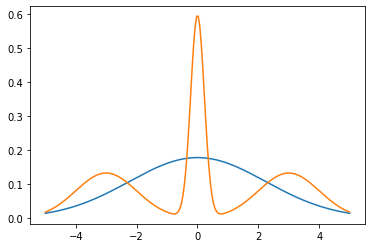

In [3]:
# proposal = distributions.Gaussian([0]*50, 1)
# target = distributions.Gaussian([2]*50, 1)

proposal = distributions.Gaussian(0, 5)
# target = distributions.GaussianMixture([-3, 0, 1], [1, 0.05, 2], [1,1,1])
target = distributions.GaussianMixture([-3, 0, 3], [1, 0.05, 1], [1,1,1])
sizes = [2, 2, 1]

plot.plot_fun(proposal.pdf)
plot.plot_fun(target.pdf, label="Target")

In [4]:
def get_ksds(proposal, kernel):
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(400)
        ksds.append(compute_ksd(samples))
    return ksds

# Train

In [5]:
learning_rate = 1e-2
learner = discrepancy_learner.SDLearner(key, target, sizes, learning_rate, lambda_reg=1)

In [13]:
samples = proposal.sample(400)
learner.train(samples, n_steps=10**3, proposal=proposal)

100%|██████████| 1000/1000 [00:01<00:00, 953.94it/s]


In [7]:
# compute optimal KSD
def optimal_f(x):
    div = 1 if learner.lambda_reg == 0 else 2*learner.lambda_reg
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div
sds = []
for _ in range(100):
    samples = proposal.sample(400)
    sds.append(get_sd(samples, optimal_f))

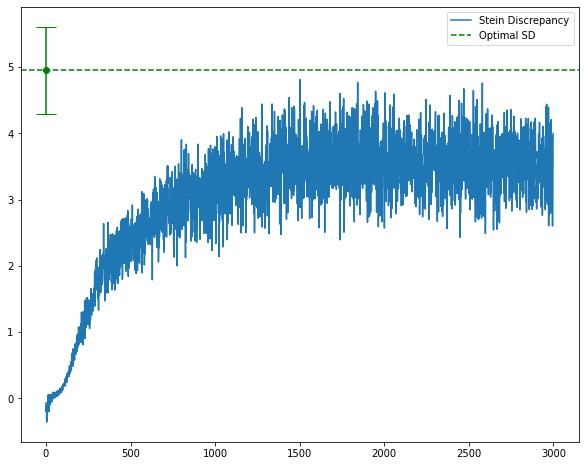

In [14]:
fig, axs = plt.subplots(figsize=[10, 8])
plt.plot(learner.rundata["training_sd"], label="Stein Discrepancy")
plt.errorbar(x=0, y=onp.mean(sds), yerr=onp.std(sds), fmt="o", capsize=10, color="green")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal SD", color="green")
plt.legend()


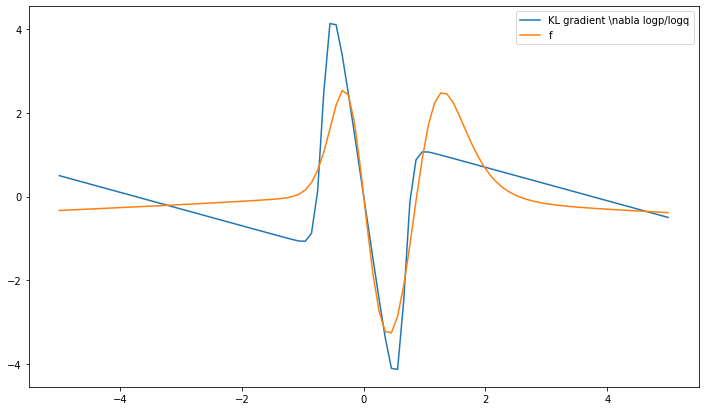

In [15]:
learned_f = learner.get_f()
phistar_rbf = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, samples)

# plot the stein gradient
scale_rbf=15
if target.d ==1:
    grid_n = 100
    grid = np.linspace(-5, 5, grid_n).reshape(grid_n, 1)
    fig, ax = plt.subplots(figsize=[12,7])
    plt.plot(grid, vmap(optimal_f)(grid), label="KL gradient \\nabla logp/logq")
    plt.plot(grid, vmap(learned_f)(grid), label="f")
#     plt.plot(grid, vmap(phistar_rbf)(grid)*scale_rbf, label="rbf phistar")

    plt.legend()

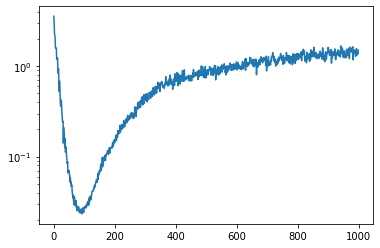

In [10]:
plt.plot(learner.rundata["fnorm"])
plt.yscale("log")